#Jorge Isidro Blanco Martínez A01745907


Cambio de dataset y objetivo
En la primera entrega probé con datos para predecir la temperatura en ciertas regiones sin embargo, no era un dataset adecuado por lo que he cambiado el dataset y objetivo por uno de análisis de sentimiento de tweets utilizando una red neuronal recurrente

Importación de librerías necesarias

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline

Construcción del primer modelo

El primer modelo cuenta con una capa LSTM bidireccional, una capa lineal y una de dropout con valor de 0.5, también definimos la función de entrenamiento que imprimirá la pérdida y precisión en el entrenamiento y validación

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        _, (hn, _) = self.rnn(x)
        hn = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)  # Concatenar las salidas bidireccionales
        hn = self.dropout(hn)
        output = self.fc(hn)
        return output

def train_rnn(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Training)'):
            optimizer.zero_grad()

            sequence_length = inputs.size(1) // input_size
            inputs = inputs.view(inputs.size(0), sequence_length, input_size)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_accuracies.append(train_accuracy)

        print(f'Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy:.4f}')

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for val_inputs, val_labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Validation)'):
                sequence_length = val_inputs.size(1) // input_size
                val_inputs = val_inputs.view(val_inputs.size(0), sequence_length, input_size)

                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                preds = torch.argmax(val_outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(val_labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            val_accuracy = accuracy_score(all_labels, all_preds)
            val_accuracies.append(val_accuracy)

            print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy:.4f}')

        scheduler.step(avg_val_loss)

    plt.figure(figsize=(12, 6))

    # Graficas Perdida
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()

    # Graficas Precision
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

Lectura de csv y visualización de la forma de los datos



In [ ]:
df = pd.read_csv('Twitter_Data.csv')

In [ ]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


Quitamos las filas con valores nulos y quitamos 130000 datos ya que google collab arroja error por la memoria

In [ ]:
df = df.dropna()
df = df.iloc[:-130000]

In [ ]:
nulos_por_columna = df.isnull().sum()

print(nulos_por_columna)

clean_text    0
category      0
dtype: int64


Inicialización del label encoder y transformación de los datos para que puedan ser utilizados por el modelo

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
df['category_encoded'] = label_encoder.fit_transform(df['category'])

Separación de los datos en entrenamiento, validación y testing

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

Vectorización de los textos en los diferentes conjuntos y conversión a matrices para su posterior conversión a tensores de pytorch para su uso en el modelo

In [ ]:
vectorizer = make_pipeline(CountVectorizer(), TfidfTransformer())
X_train = vectorizer.fit_transform(train_df['clean_text']).toarray()
X_val = vectorizer.transform(val_df['clean_text']).toarray()
X_test = vectorizer.transform(test_df['clean_text']).toarray()

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['category_encoded'].values, dtype=torch.long)
y_val_tensor = torch.tensor(val_df['category_encoded'].values, dtype=torch.long)
y_test_tensor = torch.tensor(test_df['category_encoded'].values, dtype=torch.long)


Creación de los conjuntos de datos y dataloaders, se establece el tamaño de los lotes en 32, se cambiaran aleatoriamente las muestras de cada época en el conjunto de entrenamiento

In [ ]:
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Definición de hiperparametros para el modelo como la cantidad de unidades(neuronas) en la capa oculta, numero de capas de la red así como el numero de clases. También, se define la función de pérdida y la optimización

In [ ]:
input_size = X_train_tensor.size(1)
hidden_size = 64
num_layers = 2
num_classes = len(df['category_encoded'].unique())
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Creación del scheduler con la función ReduceLRonPlateau que ajustará la tasa de aprendizaje después de 5 épocas donde no haya mejora, la reducirá multiplicandola por 0.1. Poteriormente, se hace el entrenamiento del modelo con 10 épocas

Epoch 1/10 (Training): 100%|██████████| 722/722 [03:48<00:00,  3.16it/s]


Training Loss: 0.8260627099805592, Training Accuracy: 0.6046


Epoch 1/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.49it/s]


Validation Loss: 0.4833510843015486, Validation Accuracy: 0.8202


Epoch 2/10 (Training): 100%|██████████| 722/722 [03:29<00:00,  3.45it/s]


Training Loss: 0.3176228636901547, Training Accuracy: 0.8902


Epoch 2/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.60it/s]


Validation Loss: 0.3882492017361426, Validation Accuracy: 0.8621


Epoch 3/10 (Training): 100%|██████████| 722/722 [03:12<00:00,  3.75it/s]


Training Loss: 0.14525210240809375, Training Accuracy: 0.9539


Epoch 3/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.48it/s]


Validation Loss: 0.42067400760227636, Validation Accuracy: 0.8617


Epoch 4/10 (Training): 100%|██████████| 722/722 [03:02<00:00,  3.95it/s]


Training Loss: 0.07954359017883317, Training Accuracy: 0.9776


Epoch 4/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.75it/s]


Validation Loss: 0.4657575278512893, Validation Accuracy: 0.8534


Epoch 5/10 (Training): 100%|██████████| 722/722 [03:04<00:00,  3.91it/s]


Training Loss: 0.05456656346486499, Training Accuracy: 0.9846


Epoch 5/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.54it/s]


Validation Loss: 0.5365662134462788, Validation Accuracy: 0.8508


Epoch 6/10 (Training): 100%|██████████| 722/722 [02:56<00:00,  4.08it/s]


Training Loss: 0.03585991097578374, Training Accuracy: 0.9902


Epoch 6/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.74it/s]


Validation Loss: 0.6048805213743641, Validation Accuracy: 0.8534


Epoch 7/10 (Training): 100%|██████████| 722/722 [02:55<00:00,  4.11it/s]


Training Loss: 0.02747707097523114, Training Accuracy: 0.9916


Epoch 7/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.67it/s]


Validation Loss: 0.619121493543348, Validation Accuracy: 0.8477


Epoch 8/10 (Training): 100%|██████████| 722/722 [02:55<00:00,  4.12it/s]


Training Loss: 0.022270294886952785, Training Accuracy: 0.9929


Epoch 8/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.79it/s]


Validation Loss: 0.7102635888322707, Validation Accuracy: 0.8473
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.


Epoch 9/10 (Training): 100%|██████████| 722/722 [02:56<00:00,  4.10it/s]


Training Loss: 0.013373940134137974, Training Accuracy: 0.9964


Epoch 9/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.68it/s]


Validation Loss: 0.7171791581376906, Validation Accuracy: 0.8491


Epoch 10/10 (Training): 100%|██████████| 722/722 [02:53<00:00,  4.16it/s]


Training Loss: 0.011659015063714404, Training Accuracy: 0.9964


Epoch 10/10 (Validation): 100%|██████████| 155/155 [00:09<00:00, 16.61it/s]


Validation Loss: 0.7351644842855392, Validation Accuracy: 0.8477


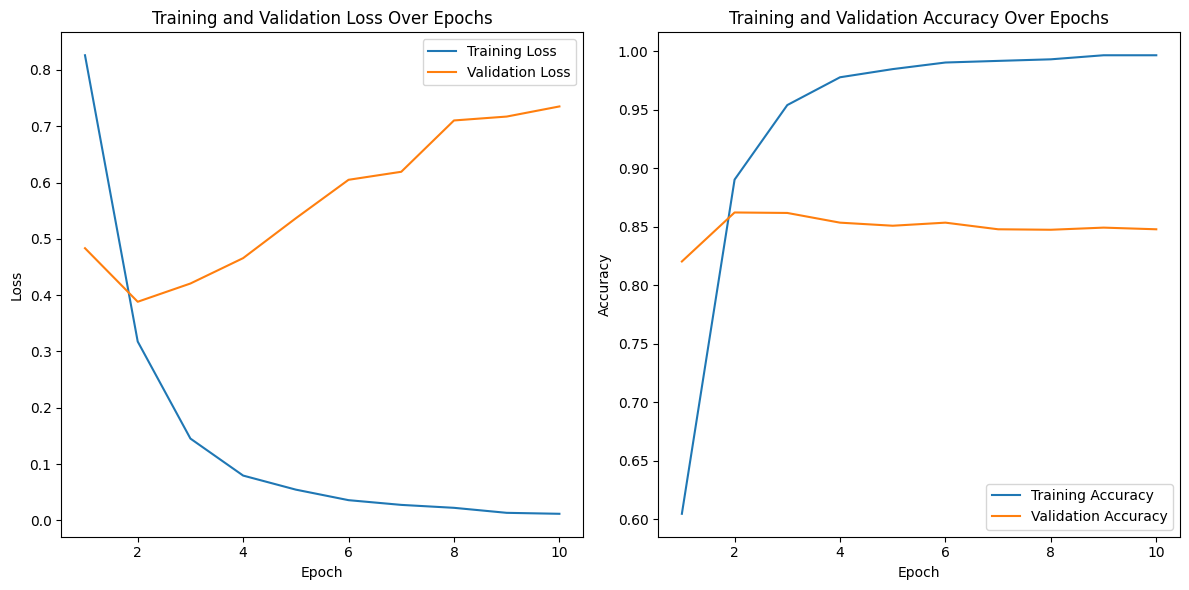

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
train_losses, val_losses, train_accuracies, val_accuracies = train_rnn(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

Con las gráficas podemos observar que el modelo parece estar overfitting ya que la pérdida en el conjunto de validación va en aumento mientras la prescisión va disminuyendo ligeramente

Prueba con los datos de testing

In [ ]:
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for test_inputs, test_labels_batch in tqdm(test_loader, desc='Final Evaluation'):
        # Redimensiona los datos para agregar la dimensión de la secuencia
        sequence_length = test_inputs.size(1) // input_size
        test_inputs = test_inputs.view(test_inputs.size(0), sequence_length, input_size)

        test_outputs = model(test_inputs)
        preds = torch.argmax(test_outputs, dim=1).cpu().numpy()
        test_preds.extend(preds.tolist())
        test_labels.extend(test_labels_batch.cpu().numpy().tolist())

# Calcular la precisión usando NumPy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Evaluation: 100%|██████████| 155/155 [00:09<00:00, 16.16it/s]

Final Test Accuracy: 0.8423


Debido a la precisión que hay en el conjunto de validación decido ver los datos para identificar alguna anomalía en los datos

In [6]:
df = pd.read_csv('Twitter_Data.csv')
df = df.dropna()

In [7]:
count_by_category = df['category'].value_counts()
print(count_by_category)

 1.0    72249
 0.0    55211
-1.0    35509
Name: category, dtype: int64


Como podemos observar los datos están muy desbalanceados, teniendo practicamente el doble de tweets positivos que negativos

In [8]:
indices = df[df['category'] == 1.0].head(62000).index
df.drop(indices, inplace=True)
indices = df[df['category'] == 0.0].head(45000).index
df.drop(indices, inplace=True)
indices = df[df['category'] == -1.0].head(25000).index
df.drop(indices, inplace=True)

In [9]:
count_by_category = df['category'].value_counts()
print(count_by_category)

-1.0    10509
 1.0    10249
 0.0    10211
Name: category, dtype: int64


Dejo el dataset con alrededor de 10 mil tweets para cada categoría

Repito el proceso de adaptación de los datos

In [10]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [11]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [12]:
vectorizer = make_pipeline(CountVectorizer(), TfidfTransformer())
X_train = vectorizer.fit_transform(train_df['clean_text']).toarray()
X_val = vectorizer.transform(val_df['clean_text']).toarray()
X_test = vectorizer.transform(test_df['clean_text']).toarray()

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['category_encoded'].values, dtype=torch.long)
y_val_tensor = torch.tensor(val_df['category_encoded'].values, dtype=torch.long)
y_test_tensor = torch.tensor(test_df['category_encoded'].values, dtype=torch.long)

In [14]:
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Hago modificaciones al modelo agregando bidireccionalidad a la capa LSTM lo que hará que el modelo analice la secuencia en ambas direcciones tratando de encontrar patrones. además, agrego otra capa de dropout y aumento en 0.1 la tasa de dropout para prevenir el overfitting que vimos en la primera aproximación

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.6):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        _, (hn, _) = self.rnn(x)
        hn = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)  # Concatenar las salidas bidireccionales
        hn = self.dropout1(hn)
        output = self.fc(hn)
        output = self.dropout2(output)
        return output



Modificamos la función de entrenamiento para añadir un early stopping para detener el entrenamiento cuando se vea una mayor pérdida en la validación

In [25]:
def train_rnn(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=5, num_epochs=1):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Training)'):
            optimizer.zero_grad()

            sequence_length = inputs.size(1) // input_size
            inputs = inputs.view(inputs.size(0), sequence_length, input_size)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_accuracies.append(train_accuracy)

        print(f'Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy:.4f}')

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for val_inputs, val_labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Validation)'):
                sequence_length = val_inputs.size(1) // input_size
                val_inputs = val_inputs.view(val_inputs.size(0), sequence_length, input_size)

                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                preds = torch.argmax(val_outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(val_labels.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            val_accuracy = accuracy_score(all_labels, all_preds)
            val_accuracies.append(val_accuracy)

            print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy:.4f}')

        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            num_epochs = epoch + 1
            print(f'Early stopping at epoch {epoch + 1}')
            break

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

Para este segundo modelo hacemos shuffle también en los datos de validación como habíamos hecho anteriormente con los de entrenamiento

In [18]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [19]:
input_size = X_train_tensor.size(1)
hidden_size = 64
num_layers = 2
num_classes = len(df['category_encoded'].unique())

In [20]:
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

Se realiza el entrenamiento del nuevo modelo

Epoch 1/100 (Training): 100%|██████████| 678/678 [03:11<00:00,  3.54it/s]


Training Loss: 1.0405879592121878, Training Accuracy: 0.4210


Epoch 1/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.50it/s]


Validation Loss: 0.7781827568191372, Validation Accuracy: 0.7145


Epoch 2/100 (Training): 100%|██████████| 678/678 [03:06<00:00,  3.64it/s]


Training Loss: 0.8008036840278491, Training Accuracy: 0.5829


Epoch 2/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.88it/s]


Validation Loss: 0.5422624223036309, Validation Accuracy: 0.8157


Epoch 3/100 (Training): 100%|██████████| 678/678 [02:51<00:00,  3.96it/s]


Training Loss: 0.6708337127019522, Training Accuracy: 0.6401


Epoch 3/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.90it/s]


Validation Loss: 0.46265217641445056, Validation Accuracy: 0.8375


Epoch 4/100 (Training): 100%|██████████| 678/678 [02:42<00:00,  4.16it/s]


Training Loss: 0.6035828790833465, Training Accuracy: 0.6625


Epoch 4/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.62it/s]


Validation Loss: 0.4382685408608554, Validation Accuracy: 0.8353


Epoch 5/100 (Training): 100%|██████████| 678/678 [02:37<00:00,  4.31it/s]


Training Loss: 0.5611772381186837, Training Accuracy: 0.6774


Epoch 5/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.74it/s]


Validation Loss: 0.41435470886222303, Validation Accuracy: 0.8426


Epoch 6/100 (Training): 100%|██████████| 678/678 [02:32<00:00,  4.44it/s]


Training Loss: 0.5324593150993716, Training Accuracy: 0.6892


Epoch 6/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.59it/s]


Validation Loss: 0.40857992698884993, Validation Accuracy: 0.8456


Epoch 7/100 (Training): 100%|██████████| 678/678 [02:31<00:00,  4.47it/s]


Training Loss: 0.5079203531102093, Training Accuracy: 0.6974


Epoch 7/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.74it/s]


Validation Loss: 0.4080640383779186, Validation Accuracy: 0.8446


Epoch 8/100 (Training): 100%|██████████| 678/678 [02:27<00:00,  4.58it/s]


Training Loss: 0.4985777581423785, Training Accuracy: 0.6973


Epoch 8/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.75it/s]


Validation Loss: 0.41884606413237035, Validation Accuracy: 0.8424


Epoch 9/100 (Training): 100%|██████████| 678/678 [02:25<00:00,  4.68it/s]


Training Loss: 0.49183538958298423, Training Accuracy: 0.7015


Epoch 9/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.85it/s]


Validation Loss: 0.42943380538323156, Validation Accuracy: 0.8448


Epoch 10/100 (Training): 100%|██████████| 678/678 [02:24<00:00,  4.69it/s]


Training Loss: 0.4795647429681457, Training Accuracy: 0.7073


Epoch 10/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.79it/s]


Validation Loss: 0.4415680909248656, Validation Accuracy: 0.8422


Epoch 11/100 (Training): 100%|██████████| 678/678 [02:25<00:00,  4.65it/s]


Training Loss: 0.4737712007048911, Training Accuracy: 0.7065


Epoch 11/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 18.00it/s]


Validation Loss: 0.4773261112301317, Validation Accuracy: 0.8381


Epoch 12/100 (Training): 100%|██████████| 678/678 [02:24<00:00,  4.70it/s]


Training Loss: 0.47123381787784685, Training Accuracy: 0.7012


Epoch 12/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.89it/s]


Validation Loss: 0.470919425356878, Validation Accuracy: 0.8420
Early stopping at epoch 12


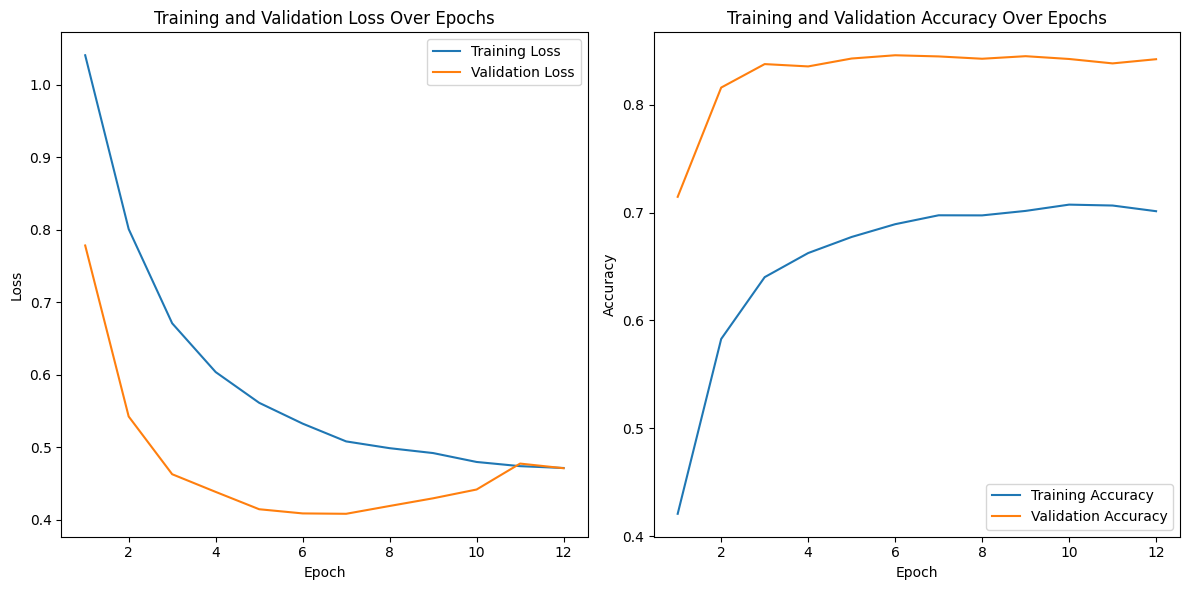

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_rnn(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100)

En este nuevo modelo podemos ver un mayor avance en las épocas sin embargo, a partir de la época 8 la pérdida en el conjunto de validación sube bastante

In [ ]:
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for test_inputs, test_labels_batch in tqdm(test_loader, desc='Final Evaluation'):
        sequence_length = test_inputs.size(1) // input_size
        test_inputs = test_inputs.view(test_inputs.size(0), sequence_length, input_size)

        test_outputs = model(test_inputs)
        preds = torch.argmax(test_outputs, dim=1).cpu().numpy()
        test_preds.extend(preds.tolist())
        test_labels.extend(test_labels_batch.cpu().numpy().tolist())

test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Evaluation: 100%|██████████| 146/146 [00:08<00:00, 17.57it/s]


Final Test Accuracy: 0.8424


Tercer modelo, agregamos una capa de normalización que nos ayudará a regularizar previniendo el sobreajuste y generalizando mejor ya que añade ruido a la activación de cada neurona, bajamos un poco el dropout rate ya que tenemos dos capas de dropout y en el modelo anterior vemos poco accuracy en el entrenamiento

In [65]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        _, (hn, _) = self.rnn(x)
        hn = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)
        hn = self.batch_norm(hn)
        hn = self.dropout1(hn)
        output = self.fc(hn)
        output = self.dropout2(output)
        return output

In [66]:
model = RNNClassifier(input_size, hidden_size, num_layers, num_classes)

Bajamos el learning rate para que el modelo dé "pasos" más pequeños y pueda generalizar mejor



Epoch 1/100 (Training): 100%|██████████| 678/678 [03:09<00:00,  3.58it/s]


Training Loss: 1.2880146061248836, Training Accuracy: 0.3456


Epoch 1/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.12it/s]


Validation Loss: 1.0693587383178815, Validation Accuracy: 0.4431


Epoch 2/100 (Training): 100%|██████████| 678/678 [02:34<00:00,  4.38it/s]


Training Loss: 1.1731882204348358, Training Accuracy: 0.3721


Epoch 2/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.16it/s]


Validation Loss: 1.0452560500739372, Validation Accuracy: 0.5119


Epoch 3/100 (Training): 100%|██████████| 678/678 [02:20<00:00,  4.82it/s]


Training Loss: 1.1156580383974541, Training Accuracy: 0.3978


Epoch 3/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.90it/s]


Validation Loss: 1.0116590339027038, Validation Accuracy: 0.5668


Epoch 4/100 (Training): 100%|██████████| 678/678 [02:15<00:00,  5.00it/s]


Training Loss: 1.0746078165934851, Training Accuracy: 0.4249


Epoch 4/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.14it/s]


Validation Loss: 0.9641040690141182, Validation Accuracy: 0.6215


Epoch 5/100 (Training): 100%|██████████| 678/678 [02:11<00:00,  5.17it/s]


Training Loss: 1.0118127429204, Training Accuracy: 0.4734


Epoch 5/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.30it/s]


Validation Loss: 0.898525547491361, Validation Accuracy: 0.6657


Epoch 6/100 (Training): 100%|██████████| 678/678 [02:08<00:00,  5.28it/s]


Training Loss: 0.9478253426805007, Training Accuracy: 0.5174


Epoch 6/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.89it/s]


Validation Loss: 0.8199514228187196, Validation Accuracy: 0.6992


Epoch 7/100 (Training): 100%|██████████| 678/678 [02:06<00:00,  5.35it/s]


Training Loss: 0.8839912379385799, Training Accuracy: 0.5553


Epoch 7/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.02it/s]


Validation Loss: 0.7541153092090398, Validation Accuracy: 0.7214


Epoch 8/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.38it/s]


Training Loss: 0.8242203112372958, Training Accuracy: 0.5876


Epoch 8/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.84it/s]


Validation Loss: 0.6900053828546445, Validation Accuracy: 0.7473


Epoch 9/100 (Training): 100%|██████████| 678/678 [02:06<00:00,  5.38it/s]


Training Loss: 0.7752173495503654, Training Accuracy: 0.6138


Epoch 9/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.91it/s]


Validation Loss: 0.6357956634808893, Validation Accuracy: 0.7668


Epoch 10/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]


Training Loss: 0.7298627813569213, Training Accuracy: 0.6335


Epoch 10/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.95it/s]


Validation Loss: 0.601761493984967, Validation Accuracy: 0.7787


Epoch 11/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.39it/s]


Training Loss: 0.690195724104358, Training Accuracy: 0.6507


Epoch 11/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.14it/s]


Validation Loss: 0.567784676608974, Validation Accuracy: 0.7903


Epoch 12/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.42it/s]


Training Loss: 0.6556143745296472, Training Accuracy: 0.6683


Epoch 12/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.84it/s]


Validation Loss: 0.5376786908058271, Validation Accuracy: 0.8022


Epoch 13/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.38it/s]


Training Loss: 0.636477170396695, Training Accuracy: 0.6773


Epoch 13/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.93it/s]


Validation Loss: 0.5140559792722741, Validation Accuracy: 0.8112


Epoch 14/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.41it/s]


Training Loss: 0.6103676962817313, Training Accuracy: 0.6851


Epoch 14/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.13it/s]


Validation Loss: 0.49733835438342944, Validation Accuracy: 0.8164


Epoch 15/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]


Training Loss: 0.5838666264198523, Training Accuracy: 0.7021


Epoch 15/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.15it/s]


Validation Loss: 0.48431804888460733, Validation Accuracy: 0.8207


Epoch 16/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.41it/s]


Training Loss: 0.5660907469228306, Training Accuracy: 0.7039


Epoch 16/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.90it/s]


Validation Loss: 0.471683860743699, Validation Accuracy: 0.8252


Epoch 17/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.39it/s]


Training Loss: 0.5608978535661303, Training Accuracy: 0.7061


Epoch 17/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.02it/s]


Validation Loss: 0.46523205333784834, Validation Accuracy: 0.8276


Epoch 18/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]


Training Loss: 0.5385996119330766, Training Accuracy: 0.7146


Epoch 18/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.88it/s]


Validation Loss: 0.4547835980376152, Validation Accuracy: 0.8282


Epoch 19/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.39it/s]


Training Loss: 0.5160515917833224, Training Accuracy: 0.7277


Epoch 19/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.14it/s]


Validation Loss: 0.44132197240035825, Validation Accuracy: 0.8325


Epoch 20/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]


Training Loss: 0.5167902653987428, Training Accuracy: 0.7208


Epoch 20/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.83it/s]


Validation Loss: 0.4407236741421974, Validation Accuracy: 0.8329


Epoch 21/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.42it/s]


Training Loss: 0.5119852897516043, Training Accuracy: 0.7257


Epoch 21/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.14it/s]


Validation Loss: 0.4322466379771494, Validation Accuracy: 0.8375


Epoch 22/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.42it/s]


Training Loss: 0.4969986358926711, Training Accuracy: 0.7366


Epoch 22/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.93it/s]


Validation Loss: 0.42799819740530565, Validation Accuracy: 0.8368


Epoch 23/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]


Training Loss: 0.4849959857827794, Training Accuracy: 0.7371


Epoch 23/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.36it/s]


Validation Loss: 0.4283297417098529, Validation Accuracy: 0.8411


Epoch 24/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]


Training Loss: 0.48105566840959507, Training Accuracy: 0.7385


Epoch 24/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.76it/s]


Validation Loss: 0.42692429653994024, Validation Accuracy: 0.8388


Epoch 25/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.42it/s]


Training Loss: 0.4696834184954652, Training Accuracy: 0.7463


Epoch 25/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.87it/s]


Validation Loss: 0.4236328397711662, Validation Accuracy: 0.8409


Epoch 26/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.42it/s]


Training Loss: 0.4642480084546196, Training Accuracy: 0.7467


Epoch 26/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.74it/s]


Validation Loss: 0.42077373988824346, Validation Accuracy: 0.8403


Epoch 27/100 (Training): 100%|██████████| 678/678 [02:04<00:00,  5.43it/s]


Training Loss: 0.4543953989811, Training Accuracy: 0.7494


Epoch 27/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.83it/s]


Validation Loss: 0.42280092427175336, Validation Accuracy: 0.8420


Epoch 28/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.39it/s]


Training Loss: 0.45277568174850275, Training Accuracy: 0.7499


Epoch 28/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.01it/s]


Validation Loss: 0.4173423027339047, Validation Accuracy: 0.8437


Epoch 29/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.42it/s]


Training Loss: 0.4467137280554898, Training Accuracy: 0.7491


Epoch 29/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.93it/s]


Validation Loss: 0.42318020771219306, Validation Accuracy: 0.8446


Epoch 30/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.41it/s]


Training Loss: 0.44450117278415546, Training Accuracy: 0.7524


Epoch 30/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.28it/s]


Validation Loss: 0.42600197600175255, Validation Accuracy: 0.8439


Epoch 31/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.41it/s]


Training Loss: 0.4377235914401952, Training Accuracy: 0.7548


Epoch 31/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.89it/s]


Validation Loss: 0.4239354341303649, Validation Accuracy: 0.8392


Epoch 32/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.41it/s]


Training Loss: 0.4335039603059622, Training Accuracy: 0.7586


Epoch 32/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.21it/s]


Validation Loss: 0.42198544495726287, Validation Accuracy: 0.8426


Epoch 33/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.40it/s]


Training Loss: 0.43287913749615353, Training Accuracy: 0.7561


Epoch 33/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.80it/s]


Validation Loss: 0.41672698459396623, Validation Accuracy: 0.8435


Epoch 34/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.41it/s]


Training Loss: 0.41786585405337073, Training Accuracy: 0.7569


Epoch 34/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.17it/s]


Validation Loss: 0.42282842334410914, Validation Accuracy: 0.8426


Epoch 35/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.42it/s]


Training Loss: 0.4257103362090468, Training Accuracy: 0.7563


Epoch 35/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.71it/s]


Validation Loss: 0.4314011172072528, Validation Accuracy: 0.8405


Epoch 36/100 (Training): 100%|██████████| 678/678 [02:04<00:00,  5.43it/s]


Training Loss: 0.4181319306821598, Training Accuracy: 0.7592


Epoch 36/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 17.10it/s]


Validation Loss: 0.42188021892758265, Validation Accuracy: 0.8465


Epoch 37/100 (Training): 100%|██████████| 678/678 [02:05<00:00,  5.41it/s]


Training Loss: 0.41761033118298624, Training Accuracy: 0.7596


Epoch 37/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.98it/s]


Validation Loss: 0.426407594093415, Validation Accuracy: 0.8450


Epoch 38/100 (Training): 100%|██████████| 678/678 [02:04<00:00,  5.45it/s]


Training Loss: 0.40370000408726103, Training Accuracy: 0.7629


Epoch 38/100 (Validation): 100%|██████████| 146/146 [00:08<00:00, 16.95it/s]


Validation Loss: 0.42653294935286656, Validation Accuracy: 0.8463
Early stopping at epoch 38


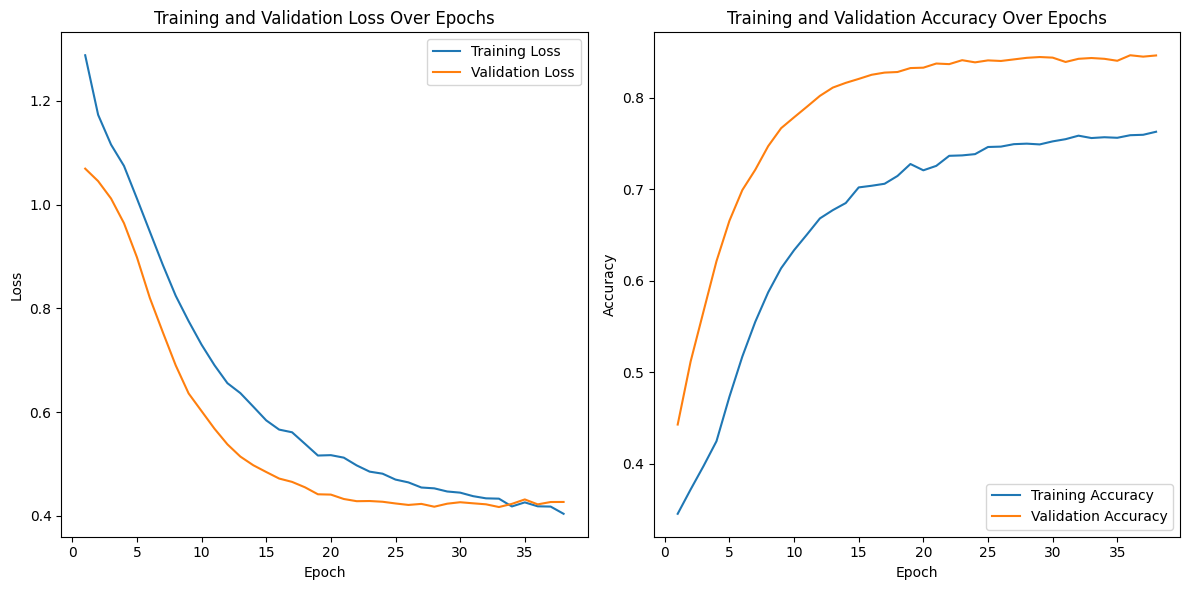

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
train_losses, val_losses, train_accuracies, val_accuracies = train_rnn(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100)

In [68]:
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for test_inputs, test_labels_batch in tqdm(test_loader, desc='Final Evaluation'):
        # Redimensiona los datos para agregar la dimensión de la secuencia
        sequence_length = test_inputs.size(1) // input_size
        test_inputs = test_inputs.view(test_inputs.size(0), sequence_length, input_size)

        test_outputs = model(test_inputs)
        preds = torch.argmax(test_outputs, dim=1).cpu().numpy()
        test_preds.extend(preds.tolist())
        test_labels.extend(test_labels_batch.cpu().numpy().tolist())

# Calcular la precisión usando NumPy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Evaluation: 100%|██████████| 146/146 [00:09<00:00, 15.67it/s]

Final Test Accuracy: 0.8455


Función para probar el modelo

In [69]:
def predict_sentiment(model, text, vectorizer):
    text_vectorized = vectorizer.transform([text]).toarray()

    text_tensor = torch.tensor(text_vectorized, dtype=torch.float32)

    sequence_length = text_tensor.size(1) // input_size
    text_tensor = text_tensor.view(1, sequence_length, input_size)

    model.eval()
    with torch.no_grad():
        output = model(text_tensor)

    predicted_label = torch.argmax(output, dim=1).item()

    return predicted_label


Prueba del modelo, se cambia el input text
Categorías:
-1 : Sentimiento Negativo
0 : Sentimiento neutral
1: Sentimiento positivo

In [70]:
input_text = "I want a donut"
predicted_label = predict_sentiment(model, input_text, vectorizer)

predicted_category = label_encoder.inverse_transform([predicted_label])[0]
print(f'Predicted Category: {predicted_category}')

Predicted Category: 0.0


#Conclusiones
El modelo tiene alrededor del 84% de precisión que para un modelo de clasificación de 3 clases es un buen porcentaje, las áreas de oportunidad que detecto en el modelo son la mejora en la precisión del conjunto de entrenamiento ya que no logré encontrar por que tiene mejor rendimiento en el set de validación o al menos no pude encontrar el equilibrio sin que el modelo cayera en overfitting